# Ridge regression with polynomial features of degree 2
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os
import scipy.stats as st

In [2]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- randomized parameter search with cross validation to find optimal values for the alpha parameter

Note - to limit the training time, the number of iterations for the randomized search has been set to 20. This should train in about 3 minutes. increasing the number of iterations will increase the likelihood of finding the optimum solution but also increase training times. 

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [17]:
param_dist = {'alpha': st.uniform(1e-4, 5.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_trai...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [21]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [22]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,8.849869,0.060166,-1239.853507,-1044.918247,0.967198,{'alpha': 0.967197577009},1,-1373.529873,-1013.126827,-1078.334000,-1077.359956,-1267.696649,-1044.267958,1.131121,0.009999,122.110827,26.227096
12,8.267557,0.082501,-1239.920211,-1043.850763,0.844203,{'alpha': 0.844203103372},2,-1373.570111,-1011.286617,-1078.285115,-1076.547934,-1267.905406,-1043.717739,2.048888,0.034032,122.162966,26.642987
19,6.312211,0.067837,-1240.576119,-1049.622015,1.5449,{'alpha': 1.54490337629},3,-1375.726300,-1021.417679,-1078.741323,-1080.824880,-1267.260735,-1046.623485,0.682227,0.019686,122.703085,24.345394
5,8.170029,0.069166,-1240.580425,-1041.058267,0.546113,{'alpha': 0.54611255133},4,-1374.766486,-1006.562817,-1078.273445,-1074.345379,-1268.701344,-1042.266607,0.807044,0.026478,122.665182,27.685303
6,8.119887,0.071669,-1241.075849,-1051.081044,1.73142,{'alpha': 1.73141689807},5,-1377.047761,-1024.029246,-1078.928179,-1081.881298,-1267.251607,-1047.332589,2.152161,0.010680,123.106185,23.766267


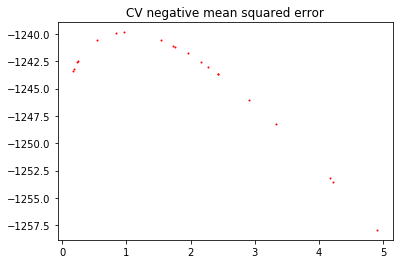

In [25]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()